# P-value Correlations as Tissues are Removed

Demonstrate change in pvalue correlation as primary tissues are removed

# Inputs

In [1]:
import rnaseq_lib3 as r
import pandas as pd
import scipy.stats as st
import pymc3 as pm
import numpy as np
import time
import os
from tqdm import tqdm_notebook as tqdm

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Read in centered data
df = pd.read_hdf('/mnt/data/expression/tcga_gtex_tpm_norm_filt.hd5')
# Subset
gtex = df[df.label == 'gtex'].sort_values('tissue')
normal = df[df.label == 'tcga-normal'].sort_values('tissue')
tumor = df[df.label == 'tcga-tumor'].sort_values('tissue')
# Read in drug genes
genes = df.columns[5:]
drug_genes = [x.split('\t')[0] for x in open('../data/druggable-genes.tsv', 'r').readlines()]
drug_genes = [x for x in drug_genes if x in df.columns]

In [3]:
out_dir = '/mnt/research_serializations/Pval-Correlations-as-Tissues-Removed'

In [31]:
def protocol(sample, df, genes, tissue, i, last=False):
    out = os.path.join(out_dir, f'{sample.id}-{tissue}-{i}.pkl')
    if os.path.exists(out):
        m, t = r.outlier.load_model(out)
    else:
        training_genes = r.outlier.select_k_best_genes(df, genes, 'tissue', 15)
        training_genes = training_genes + drug_genes
        # Run model
        m, t = r.outlier.run_model(sample, df, training_genes, 'tissue')
        r.outlier.pickle_model(out, m, t)
    
    if last:
        ppc = {}
        for gene in drug_genes:
            y_gene = [x for x in t.varnames if x.startswith(f'{gene}-')]
            b = t['a']
            for i, y_name in enumerate(y_gene):
                b += 1 * t[y_name]
            ppc[gene] = np.random.laplace(loc=b, scale=t['eps'])
        weights = [1]
    else:
        ppc = r.outlier.ppc(t, drug_genes)
        groups = df.tissue.unique()
        weights = r.outlier.calculate_weights(groups, t)
    ppp = r.outlier.posterior_predictive_pvals(sample, ppc)
    return ppp, weights

# Adrenal

In [ ]:
tissue = 'Adrenal'
ran_sample = np.random.choice(tumor[tumor.tissue == tissue].index)
sample = tumor.loc[ran_sample]

In [ ]:
# Choose training set
ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]

pvals = []
for i in range(5):
    print(training_group.tissue.unique())
    last = True if i == 4 else False
    ppp, weights = protocol(sample, training_group, genes, tissue, i, last=last)
    pvals.append(ppp)
    if last:
        continue
    tissue_to_remove = weights.groupby('Class').mean().sort_values('Weights', ascending=False).index[0]
    print(f'Removing {tissue_to_remove}')
    training_group = training_group[training_group.tissue != tissue_to_remove]
pvals = pd.concat(pvals, axis=1)

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i in range(4):
    pr, pval = st.pearsonr(pvals[0], pvals[i+1])
    sns.regplot(pvals[0], pvals[i+1], label=i+1, ax=ax[i])
    ax[i].text(0.2, 0.8, f'PR: {round(pr, 2)}')
    ax[i].set_title(f'Minus-{i+1} Tissue')
plt.suptitle(tissue)
plt.tight_layout()

# Bile

In [ ]:
tissue = 'Bile'
ran_sample = np.random.choice(tumor[tumor.tissue == tissue].index)
sample = tumor.loc[ran_sample]

In [ ]:
# Choose training set
ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]

pvals = []
for i in range(5):
    print(training_group.tissue.unique())
    last = True if i == 4 else False
    ppp, weights = protocol(sample, training_group, genes, tissue, i, last=last)
    pvals.append(ppp)
    if last:
        continue
    tissue_to_remove = weights.groupby('Class').mean().sort_values('Weights', ascending=False).index[0]
    print(f'Removing {tissue_to_remove}')
    training_group = training_group[training_group.tissue != tissue_to_remove]
pvals = pd.concat(pvals, axis=1)

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i in range(4):
    pr, pval = st.pearsonr(pvals[0], pvals[i+1])
    sns.regplot(pvals[0], pvals[i+1], label=i+1, ax=ax[i])
    ax[i].text(0.2, 0.8, f'PR: {round(pr, 2)}')
    ax[i].set_title(f'Minus-{i+1} Tissue')
plt.suptitle(tissue)
plt.tight_layout()

# Bladder

In [ ]:
tissue = 'Bladder'
ran_sample = np.random.choice(tumor[tumor.tissue == tissue].index)
sample = tumor.loc[ran_sample]

In [ ]:
# Choose training set
ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]

pvals = []
for i in range(5):
    print(training_group.tissue.unique())
    last = True if i == 4 else False
    ppp, weights = protocol(sample, training_group, drug_genes, tissue, i, last=last)
    pvals.append(ppp)
    if last:
        continue
    tissue_to_remove = weights.groupby('Class').mean().sort_values('Weights', ascending=False).index[0]
    print(f'Removing {tissue_to_remove}')
    training_group = training_group[training_group.tissue != tissue_to_remove]
pvals = pd.concat(pvals, axis=1)

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i in range(4):
    pr, pval = st.pearsonr(pvals[0], pvals[i+1])
    sns.regplot(pvals[0], pvals[i+1], label=i+1, ax=ax[i])
    ax[i].text(0.2, 0.8, f'PR: {round(pr, 2)}')
    ax[i].set_title(f'Minus-{i+1} Tissue')
plt.suptitle(tissue)
plt.tight_layout()

# Brain

In [35]:
tissue = 'Brain'
ran_sample = np.random.choice(tumor[tumor.tissue == tissue].index)
sample = tumor.loc[ran_sample]
sample = tumor.loc['TCGA-FG-A4MX-01']

In [36]:
# Choose training set
ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]

pvals = []
for i in range(5):
    print(training_group.tissue.unique())
    last = True if i == 4 else False
    ppp, weights = protocol(sample, training_group, genes, tissue, i, last=last)
    pvals.append(ppp)
    if last:
        continue
    tissue_to_remove = weights.groupby('Class').mean().sort_values('Weights', ascending=False).index[0]
    print(f'Removing {tissue_to_remove}')
    training_group = training_group[training_group.tissue != tissue_to_remove]
pvals = pd.concat(pvals, axis=1)

['Adrenal' 'Brain' 'Colon' 'Kidney' 'Pituitary']
Removing Brain
['Adrenal' 'Colon' 'Kidney' 'Pituitary']
Removing Colon
['Adrenal' 'Kidney' 'Pituitary']
Removing Pituitary
['Adrenal' 'Kidney']
Removing Adrenal
['Kidney']


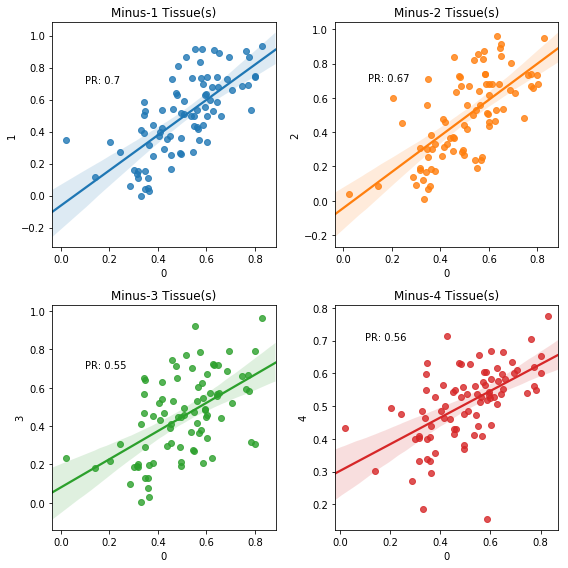

In [40]:
f, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i in range(4):
    pr, pval = st.pearsonr(pvals[0], pvals[i+1])
    sns.regplot(pvals[0], pvals[i+1], label=i+1, ax=ax[i])
    ax[i].text(0.1, 0.7, f'PR: {round(pr, 2)}')
    ax[i].set_title(f'Minus-{i+1} Tissue(s)')
#plt.suptitle(tissue)
plt.tight_layout()

# Breast

In [8]:
tissue = 'Breast'
ran_sample = np.random.choice(tumor[tumor.tissue == tissue].index)
sample = tumor.loc[ran_sample]

In [9]:
# Choose training set
ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]

pvals = []
for i in range(5):
    print(training_group.tissue.unique())
    last = True if i == 4 else False
    ppp, weights = protocol(sample, training_group, genes, tissue, i, last=last)
    pvals.append(ppp)
    if last:
        continue
    tissue_to_remove = weights.groupby('Class').mean().sort_values('Weights', ascending=False).index[0]
    print(f'Removing {tissue_to_remove}')
    training_group = training_group[training_group.tissue != tissue_to_remove]
pvals = pd.concat(pvals, axis=1)

['Bladder' 'Breast' 'Cervix' 'Lung' 'Minor']
Building model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PARP1-Minor, PARP1-Lung, PARP1-Cervix, PARP1-Breast, PARP1-Bladder, AURKC-Minor, AURKC-Lung, AURKC-Cervix, AURKC-Breast, AURKC-Bladder, AURKB-Minor, AURKB-Lung, AURKB-Cervix, AURKB-Breast, AURKB-Bladder, AURKA-Minor, AURKA-Lung, AURKA-Cervix, AURKA-Breast, AURKA-Bladder, MS4A1-Minor, MS4A1-Lung, MS4A1-Cervix, MS4A1-Breast, MS4A1-Bladder, BTK-Minor, BTK-Lung, BTK-Cervix, BTK-Breast, BTK-Bladder, HSP90B1-Minor, HSP90B1-Lung, HSP90B1-Cervix, HSP90B1-Breast, HSP90B1-Bladder, HSP90AB3P-Minor, HSP90AB3P-Lung, HSP90AB3P-Cervix, HSP90AB3P-Breast, HSP90AB3P-Bladder, HSP90AB1-Minor, HSP90AB1-Lung, HSP90AB1-Cervix, HSP90AB1-Breast, HSP90AB1-Bladder, HSP90AA1-Minor, HSP90AA1-Lung, HSP90AA1-Cervix, HSP90AA1-Breast, HSP90AA1-Bladder, MDM2-Minor, MDM2-Lung, MDM2-Cervix, MDM2-Breast, MDM2-Bladder, BCL6-Minor, BCL6-Lung, BCL6-Cervix, BCL6-Breast, BCL6-Bladder, BCL2-Minor, BCL2-Lung, BCL2-Cervix, BCL2-Breast, BCL2-Bladder, SMO-Minor, SMO-Lung, SMO-Cervix

Removing Minor
['Bladder' 'Breast' 'Cervix' 'Lung']
Building model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PARP1-Lung, PARP1-Cervix, PARP1-Breast, PARP1-Bladder, AURKC-Lung, AURKC-Cervix, AURKC-Breast, AURKC-Bladder, AURKB-Lung, AURKB-Cervix, AURKB-Breast, AURKB-Bladder, AURKA-Lung, AURKA-Cervix, AURKA-Breast, AURKA-Bladder, MS4A1-Lung, MS4A1-Cervix, MS4A1-Breast, MS4A1-Bladder, BTK-Lung, BTK-Cervix, BTK-Breast, BTK-Bladder, HSP90B1-Lung, HSP90B1-Cervix, HSP90B1-Breast, HSP90B1-Bladder, HSP90AB3P-Lung, HSP90AB3P-Cervix, HSP90AB3P-Breast, HSP90AB3P-Bladder, HSP90AB1-Lung, HSP90AB1-Cervix, HSP90AB1-Breast, HSP90AB1-Bladder, HSP90AA1-Lung, HSP90AA1-Cervix, HSP90AA1-Breast, HSP90AA1-Bladder, MDM2-Lung, MDM2-Cervix, MDM2-Breast, MDM2-Bladder, BCL6-Lung, BCL6-Cervix, BCL6-Breast, BCL6-Bladder, BCL2-Lung, BCL2-Cervix, BCL2-Breast, BCL2-Bladder, SMO-Lung, SMO-Cervix, SMO-Breast, SMO-Bladder, GLI1-Lung, GLI1-Cervix, GLI1-Breast, GLI1-Bladder, PTCH1-Lung, PTCH1-Cervix, PTCH1-Breast, PTCH1-Bladder, MAP2K2-Lung, MAP2K2-Cervix, MAP2K2-Breast, MAP2K2-Blad

Removing Breast
['Bladder' 'Cervix' 'Lung']
Building model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PARP1-Lung, PARP1-Cervix, PARP1-Bladder, AURKC-Lung, AURKC-Cervix, AURKC-Bladder, AURKB-Lung, AURKB-Cervix, AURKB-Bladder, AURKA-Lung, AURKA-Cervix, AURKA-Bladder, MS4A1-Lung, MS4A1-Cervix, MS4A1-Bladder, BTK-Lung, BTK-Cervix, BTK-Bladder, HSP90B1-Lung, HSP90B1-Cervix, HSP90B1-Bladder, HSP90AB3P-Lung, HSP90AB3P-Cervix, HSP90AB3P-Bladder, HSP90AB1-Lung, HSP90AB1-Cervix, HSP90AB1-Bladder, HSP90AA1-Lung, HSP90AA1-Cervix, HSP90AA1-Bladder, MDM2-Lung, MDM2-Cervix, MDM2-Bladder, BCL6-Lung, BCL6-Cervix, BCL6-Bladder, BCL2-Lung, BCL2-Cervix, BCL2-Bladder, SMO-Lung, SMO-Cervix, SMO-Bladder, GLI1-Lung, GLI1-Cervix, GLI1-Bladder, PTCH1-Lung, PTCH1-Cervix, PTCH1-Bladder, MAP2K2-Lung, MAP2K2-Cervix, MAP2K2-Bladder, MAP2K1-Lung, MAP2K1-Cervix, MAP2K1-Bladder, ARAF-Lung, ARAF-Cervix, ARAF-Bladder, RAF1-Lung, RAF1-Cervix, RAF1-Bladder, BRAF-Lung, BRAF-Cervix, BRAF-Bladder, HRAS-Lung, HRAS-Cervix, HRAS-Bladder, KRAS-Lung, KRAS-Cervix, KRAS-Bladder, NRAS

Removing Lung
['Bladder' 'Cervix']
Building model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PARP1-Cervix, PARP1-Bladder, AURKC-Cervix, AURKC-Bladder, AURKB-Cervix, AURKB-Bladder, AURKA-Cervix, AURKA-Bladder, MS4A1-Cervix, MS4A1-Bladder, BTK-Cervix, BTK-Bladder, HSP90B1-Cervix, HSP90B1-Bladder, HSP90AB3P-Cervix, HSP90AB3P-Bladder, HSP90AB1-Cervix, HSP90AB1-Bladder, HSP90AA1-Cervix, HSP90AA1-Bladder, MDM2-Cervix, MDM2-Bladder, BCL6-Cervix, BCL6-Bladder, BCL2-Cervix, BCL2-Bladder, SMO-Cervix, SMO-Bladder, GLI1-Cervix, GLI1-Bladder, PTCH1-Cervix, PTCH1-Bladder, MAP2K2-Cervix, MAP2K2-Bladder, MAP2K1-Cervix, MAP2K1-Bladder, ARAF-Cervix, ARAF-Bladder, RAF1-Cervix, RAF1-Bladder, BRAF-Cervix, BRAF-Bladder, HRAS-Cervix, HRAS-Bladder, KRAS-Cervix, KRAS-Bladder, NRAS-Cervix, NRAS-Bladder, DEPTOR-Cervix, DEPTOR-Bladder, MLST8-Cervix, MLST8-Bladder, RPTOR-Cervix, RPTOR-Bladder, MTOR-Cervix, MTOR-Bladder, TSC2-Cervix, TSC2-Bladder, TSC1-Cervix, TSC1-Bladder, AKT3-Cervix, AKT3-Bladder, AKT1-Cervix, AKT1-Bladder, PIK3C3-Cervix, PIK3C3-Bladder,

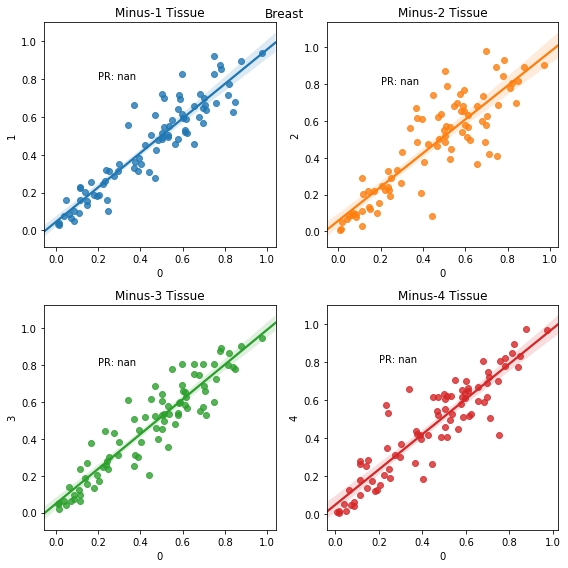

In [10]:
f, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i in range(4):
    pr, pval = st.pearsonr(pvals[0], pvals[i+1])
    sns.regplot(pvals[0], pvals[i+1], label=i+1, ax=ax[i])
    ax[i].text(0.2, 0.8, f'PR: {round(pr, 2)}')
    ax[i].set_title(f'Minus-{i+1} Tissue')
plt.suptitle(tissue)
plt.tight_layout()

# Cervix

In [ ]:
tissue = 'Cervix'
ran_sample = np.random.choice(tumor[tumor.tissue == tissue].index)
sample = tumor.loc[ran_sample]

In [ ]:
# Choose training set
ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]

pvals = []
for i in range(5):
    print(training_group.tissue.unique())
    last = True if i == 4 else False
    ppp, weights = protocol(sample, training_group, genes, tissue, i, last=last)
    pvals.append(ppp)
    if last:
        continue
    tissue_to_remove = weights.groupby('Class').mean().sort_values('Weights', ascending=False).index[0]
    print(f'Removing {tissue_to_remove}')
    training_group = training_group[training_group.tissue != tissue_to_remove]
pvals = pd.concat(pvals, axis=1)

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i in range(4):
    pr, pval = st.pearsonr(pvals[0], pvals[i+1])
    sns.regplot(pvals[0], pvals[i+1], label=i+1, ax=ax[i])
    ax[i].text(0.2, 0.8, f'PR: {round(pr, 2)}')
    ax[i].set_title(f'Minus-{i+1} Tissue')
plt.suptitle(tissue)
plt.tight_layout()

# Colon

In [41]:
tissue = 'Colon'
ran_sample = np.random.choice(tumor[tumor.tissue == tissue].index)
sample = tumor.loc[ran_sample]

In [42]:
# Choose training set
ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]

pvals = []
for i in range(5):
    print(training_group.tissue.unique())
    last = True if i == 4 else False
    ppp, weights = protocol(sample, training_group, genes, tissue, i, last=last)
    pvals.append(ppp)
    if last:
        continue
    tissue_to_remove = weights.groupby('Class').mean().sort_values('Weights', ascending=False).index[0]
    print(f'Removing {tissue_to_remove}')
    training_group = training_group[training_group.tissue != tissue_to_remove]
pvals = pd.concat(pvals, axis=1)

['Kidney' 'Minor' 'Pancreas' 'Small_intestine' 'Stomach']
Building model


INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock

Sampling 4 chains:  97%|█████████▋| 3885/4000 [14:08<00:50,  2.29draws/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Sampling 4 chains: 100%|██████████| 4000/4000 [10:45<00:00,  1.54draws/s]
The number of effective samples is smaller than 25% for some parameters.


Removing Kidney
['Minor' 'Pancreas' 'Small_intestine']
Building model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PARP1-Small_intestine, PARP1-Pancreas, PARP1-Minor, AURKC-Small_intestine, AURKC-Pancreas, AURKC-Minor, AURKB-Small_intestine, AURKB-Pancreas, AURKB-Minor, AURKA-Small_intestine, AURKA-Pancreas, AURKA-Minor, MS4A1-Small_intestine, MS4A1-Pancreas, MS4A1-Minor, BTK-Small_intestine, BTK-Pancreas, BTK-Minor, HSP90B1-Small_intestine, HSP90B1-Pancreas, HSP90B1-Minor, HSP90AB3P-Small_intestine, HSP90AB3P-Pancreas, HSP90AB3P-Minor, HSP90AB1-Small_intestine, HSP90AB1-Pancreas, 

Removing Small_intestine
['Pancreas']
Building model


INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock

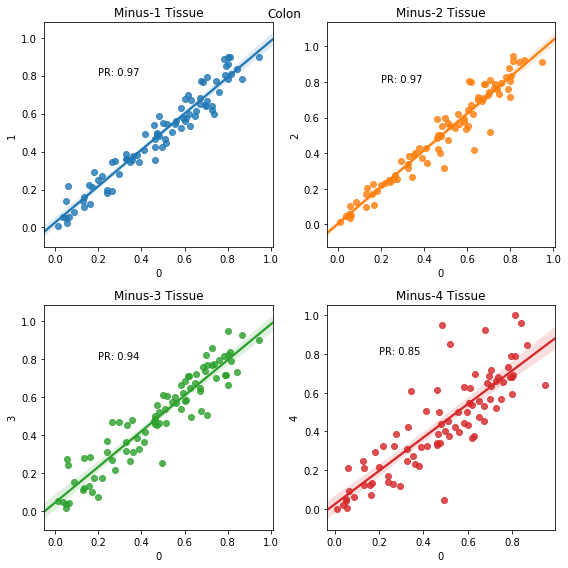

In [43]:
f, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i in range(4):
    pr, pval = st.pearsonr(pvals[0], pvals[i+1])
    sns.regplot(pvals[0], pvals[i+1], label=i+1, ax=ax[i])
    ax[i].text(0.2, 0.8, f'PR: {round(pr, 2)}')
    ax[i].set_title(f'Minus-{i+1} Tissue')
plt.suptitle(tissue)
plt.tight_layout()

# Esophagus

In [14]:
tissue = 'Esophagus'
ran_sample = np.random.choice(tumor[tumor.tissue == tissue].index)
sample = tumor.loc[ran_sample]

In [15]:
# Choose training set
ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]

pvals = []
for i in range(5):
    print(training_group.tissue.unique())
    last = True if i == 4 else False
    ppp, weights = protocol(sample, training_group, genes, tissue, i, last=last)
    pvals.append(ppp)
    if last:
        continue
    tissue_to_remove = weights.groupby('Class').mean().sort_values('Weights', ascending=False).index[0]
    print(f'Removing {tissue_to_remove}')
    training_group = training_group[training_group.tissue != tissue_to_remove]
pvals = pd.concat(pvals, axis=1)

['Colon' 'Lung' 'Minor' 'Small_intestine' 'Stomach']
Building model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PARP1-Stomach, PARP1-Small_intestine, PARP1-Minor, PARP1-Lung, PARP1-Colon, AURKC-Stomach, AURKC-Small_intestine, AURKC-Minor, AURKC-Lung, AURKC-Colon, AURKB-Stomach, AURKB-Small_intestine, AURKB-Minor, AURKB-Lung, AURKB-Colon, AURKA-Stomach, AURKA-Small_intestine, AURKA-Minor, AURKA-Lung, AURKA-Colon, MS4A1-Stomach, MS4A1-Small_intestine, MS4A1-Minor, MS4A1-Lung, MS4A1-Colon, BTK-Stomach, BTK-Small_intestine, BTK-Minor, BTK-Lung, BTK-Colon, HSP90B1-Stomach, HSP90B1-Small_intestine, HSP90B1-Minor, HSP90B1-Lung, HSP90B1-Colon, HSP90AB3P-Stomach, HSP90AB3P-Small_intestine, HSP90AB3P-Minor, HSP90AB3P-Lung, HSP90AB3P-Colon, HSP90AB1-Stomach, HSP90AB1-Small_intestine, HSP90AB1-Minor, HSP90AB1-Lung, HSP90AB1-Colon, HSP90AA1-Stomach, HSP90AA1-Small_intestine, HSP90AA1-Minor, HSP90AA1-Lung, HSP90AA1-Colon, MDM2-Stomach, MDM2-Small_intestine, MDM2-Minor, MDM2-Lung, MDM2-Colon, BCL6-Stomach, BCL6-Small_intestine, BCL6-Minor, BCL6-Lung, BCL6-Colon

Removing Minor
['Colon' 'Lung' 'Small_intestine']
Building model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PARP1-Small_intestine, PARP1-Lung, PARP1-Colon, AURKC-Small_intestine, AURKC-Lung, AURKC-Colon, AURKB-Small_intestine, AURKB-Lung, AURKB-Colon, AURKA-Small_intestine, AURKA-Lung, AURKA-Colon, MS4A1-Small_intestine, MS4A1-Lung, MS4A1-Colon, BTK-Small_intestine, BTK-Lung, BTK-Colon, HSP90B1-Small_intestine, HSP90B1-Lung, HSP90B1-Colon, HSP90AB3P-Small_intestine, HSP90AB3P-Lung, HSP90AB3P-Colon, HSP90AB1-Small_intestine, HSP90AB1-Lung, HSP90AB1-Colon, HSP90AA1-Small_intestine, HSP90AA1-Lung, HSP90AA1-Colon, MDM2-Small_intestine, MDM2-Lung, MDM2-Colon, BCL6-Small_intestine, BCL6-Lung, BCL6-Colon, BCL2-Small_intestine, BCL2-Lung, BCL2-Colon, SMO-Small_intestine, SMO-Lung, SMO-Colon, GLI1-Small_intestine, GLI1-Lung, GLI1-Colon, PTCH1-Small_intestine, PTCH1-Lung, PTCH1-Colon, MAP2K2-Small_intestine, MAP2K2-Lung, MAP2K2-Colon, MAP2K1-Small_intestine, MAP2K1-Lung, MAP2K1-Colon, ARAF-Small_intestine, ARAF-Lung, ARAF-Colon, RAF1-Small_intestine, R

Removing Colon
['Lung']
Building model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PARP1-Lung, AURKC-Lung, AURKB-Lung, AURKA-Lung, MS4A1-Lung, BTK-Lung, HSP90B1-Lung, HSP90AB3P-Lung, HSP90AB1-Lung, HSP90AA1-Lung, MDM2-Lung, BCL6-Lung, BCL2-Lung, SMO-Lung, GLI1-Lung, PTCH1-Lung, MAP2K2-Lung, MAP2K1-Lung, ARAF-Lung, RAF1-Lung, BRAF-Lung, HRAS-Lung, KRAS-Lung, NRAS-Lung, DEPTOR-Lung, MLST8-Lung, RPTOR-Lung, MTOR-Lung, TSC2-Lung, TSC1-Lung, AKT3-Lung, AKT1-Lung, PIK3C3-Lung, PIK3C2G-Lung, PIK3C2B-Lung, PIK3C2A-Lung, PIK3R6-Lung, PIK3R5-Lung, PIK3R4-Lung, PIK3R3-Lung, PIK3R2-Lung, PIK3R1-Lung, PIK3CD-Lung, PIK3CG-Lung, PIK3CB-Lung, PIK3CA-Lung, CDK2-Lung, CCNE1-Lung, CCND3-Lung, CCND2-Lung, CCND1-Lung, CDK6-Lung, CDK4-Lung, TEK-Lung, CSF1R-Lung, KIT-Lung, KDR-Lung, FLT3-Lung, NTRK3-Lung, NTRK2-Lung, NTRK1-Lung, FGFR4-Lung, FGFR3-Lung, FGFR2-Lung, FGFR1-Lung, PDGFRB-Lung, PDGFRA-Lung, FLT4-Lung, FLT1-Lung, ROS1-Lung, MET-Lung, ALK-Lung, ERBB3-Lung, ERBB2-Lung, EGFR-Lung, IL6R-Lung, IL6-Lung, STAT5B-Lung, STAT5A-Lung, STAT3-

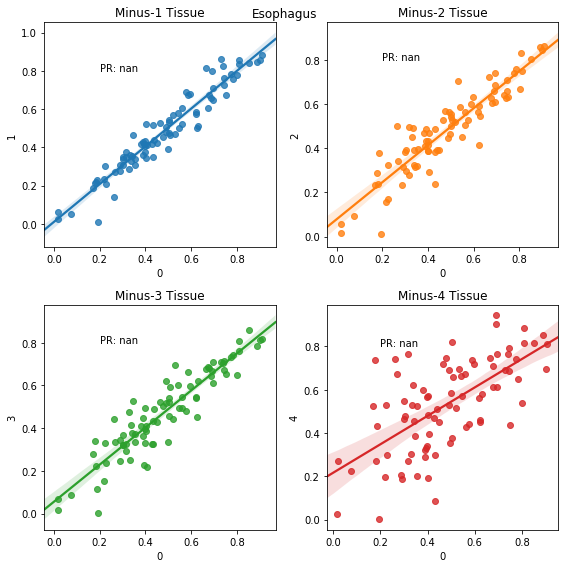

In [16]:
f, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i in range(4):
    pr, pval = st.pearsonr(pvals[0], pvals[i+1])
    sns.regplot(pvals[0], pvals[i+1], label=i+1, ax=ax[i])
    ax[i].text(0.2, 0.8, f'PR: {round(pr, 2)}')
    ax[i].set_title(f'Minus-{i+1} Tissue')
plt.suptitle(tissue)
plt.tight_layout()

# Eye

In [ ]:
tissue = 'Eye'
ran_sample = np.random.choice(tumor[tumor.tissue == tissue].index)
sample = tumor.loc[ran_sample]

In [ ]:
# Choose training set
ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]

pvals = []
for i in range(5):
    print(training_group.tissue.unique())
    last = True if i == 4 else False
    ppp, weights = protocol(sample, training_group, genes, tissue, i, last=last)
    pvals.append(ppp)
    if last:
        continue
    tissue_to_remove = weights.groupby('Class').mean().sort_values('Weights', ascending=False).index[0]
    print(f'Removing {tissue_to_remove}')
    training_group = training_group[training_group.tissue != tissue_to_remove]
pvals = pd.concat(pvals, axis=1)

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i in range(4):
    pr, pval = st.pearsonr(pvals[0], pvals[i+1])
    sns.regplot(pvals[0], pvals[i+1], label=i+1, ax=ax[i])
    ax[i].text(0.2, 0.8, f'PR: {round(pr, 2)}')
    ax[i].set_title(f'Minus-{i+1} Tissue')
plt.suptitle(tissue)
plt.tight_layout()

# Head

In [ ]:
tissue = 'Head'
ran_sample = np.random.choice(tumor[tumor.tissue == tissue].index)
sample = tumor.loc[ran_sample]

In [ ]:
# Choose training set
ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]

pvals = []
for i in range(5):
    print(training_group.tissue.unique())
    last = True if i == 4 else False
    ppp, weights = protocol(sample, training_group, genes, tissue, i, last=last)
    pvals.append(ppp)
    if last:
        continue
    tissue_to_remove = weights.groupby('Class').mean().sort_values('Weights', ascending=False).index[0]
    print(f'Removing {tissue_to_remove}')
    training_group = training_group[training_group.tissue != tissue_to_remove]
pvals = pd.concat(pvals, axis=1)

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i in range(4):
    pr, pval = st.pearsonr(pvals[0], pvals[i+1])
    sns.regplot(pvals[0], pvals[i+1], label=i+1, ax=ax[i])
    ax[i].text(0.2, 0.8, f'PR: {round(pr, 2)}')
    ax[i].set_title(f'Minus-{i+1} Tissue')
plt.suptitle(tissue)
plt.tight_layout()

# Kidney

In [ ]:
tissue = 'Kidney'
ran_sample = np.random.choice(tumor[tumor.tissue == tissue].index)
sample = tumor.loc[ran_sample]

In [ ]:
# Choose training set
ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]

pvals = []
for i in range(5):
    print(training_group.tissue.unique())
    last = True if i == 4 else False
    ppp, weights = protocol(sample, training_group, genes, tissue, i, last=last)
    pvals.append(ppp)
    if last:
        continue
    tissue_to_remove = weights.groupby('Class').mean().sort_values('Weights', ascending=False).index[0]
    print(f'Removing {tissue_to_remove}')
    training_group = training_group[training_group.tissue != tissue_to_remove]
pvals = pd.concat(pvals, axis=1)

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i in range(4):
    pr, pval = st.pearsonr(pvals[0], pvals[i+1])
    sns.regplot(pvals[0], pvals[i+1], label=i+1, ax=ax[i])
    ax[i].text(0.2, 0.8, f'PR: {round(pr, 2)}')
    ax[i].set_title(f'Minus-{i+1} Tissue')
plt.suptitle(tissue)
plt.tight_layout()

# Liver

In [ ]:
tissue = 'Liver'
ran_sample = np.random.choice(tumor[tumor.tissue == tissue].index)
sample = tumor.loc[ran_sample]

In [ ]:
# Choose training set
ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]

pvals = []
for i in range(5):
    print(training_group.tissue.unique())
    last = True if i == 4 else False
    ppp, weights = protocol(sample, training_group, genes, tissue, i, last=last)
    pvals.append(ppp)
    if last:
        continue
    tissue_to_remove = weights.groupby('Class').mean().sort_values('Weights', ascending=False).index[0]
    print(f'Removing {tissue_to_remove}')
    training_group = training_group[training_group.tissue != tissue_to_remove]
pvals = pd.concat(pvals, axis=1)

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i in range(4):
    pr, pval = st.pearsonr(pvals[0], pvals[i+1])
    sns.regplot(pvals[0], pvals[i+1], label=i+1, ax=ax[i])
    ax[i].text(0.2, 0.8, f'PR: {round(pr, 2)}')
    ax[i].set_title(f'Minus-{i+1} Tissue')
plt.suptitle(tissue)
plt.tight_layout()

# Lung

In [44]:
tissue = 'Lung'
ran_sample = np.random.choice(tumor[tumor.tissue == tissue].index)
sample = tumor.loc[ran_sample]

In [45]:
# Choose training set
ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]

pvals = []
for i in range(5):
    print(training_group.tissue.unique())
    last = True if i == 4 else False
    ppp, weights = protocol(sample, training_group, genes, tissue, i, last=last)
    pvals.append(ppp)
    if last:
        continue
    tissue_to_remove = weights.groupby('Class').mean().sort_values('Weights', ascending=False).index[0]
    print(f'Removing {tissue_to_remove}')
    training_group = training_group[training_group.tissue != tissue_to_remove]
pvals = pd.concat(pvals, axis=1)

['Breast' 'Lung' 'Minor' 'Small_intestine' 'Spleen']
Building model


INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock

Sampling 4 chains: 100%|██████████| 4000/4000 [11:31<00:00,  2.36draws/s] 


Removing Lung
['Breast' 'Minor' 'Small_intestine' 'Spleen']
Building model


INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock

Sampling 4 chains: 100%|██████████| 4000/4000 [09:01<00:00,  3.04draws/s]
The number of effective samples is smaller than 25% for some parameters.


Removing Minor
['Breast' 'Small_intestine' 'Spleen']
Building model


INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock

Removing Small_intestine
['Breast' 'Spleen']
Building model


INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock

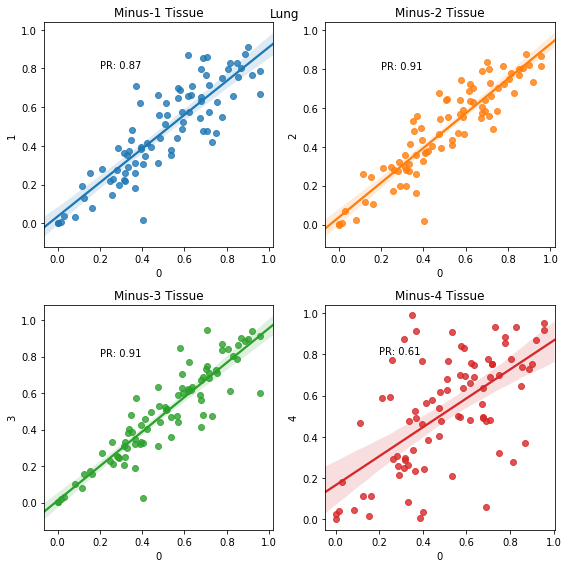

In [46]:
f, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i in range(4):
    pr, pval = st.pearsonr(pvals[0], pvals[i+1])
    sns.regplot(pvals[0], pvals[i+1], label=i+1, ax=ax[i])
    ax[i].text(0.2, 0.8, f'PR: {round(pr, 2)}')
    ax[i].set_title(f'Minus-{i+1} Tissue')
plt.suptitle(tissue)
plt.tight_layout()

# Lymph

In [ ]:
tissue = 'Lymph'
ran_sample = np.random.choice(tumor[tumor.tissue == tissue].index)
sample = tumor.loc[ran_sample]

In [ ]:
# Choose training set
ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]

pvals = []
for i in range(5):
    print(training_group.tissue.unique())
    last = True if i == 4 else False
    ppp, weights = protocol(sample, training_group, genes, tissue, i, last=last)
    pvals.append(ppp)
    if last:
        continue
    tissue_to_remove = weights.groupby('Class').mean().sort_values('Weights', ascending=False).index[0]
    print(f'Removing {tissue_to_remove}')
    training_group = training_group[training_group.tissue != tissue_to_remove]
pvals = pd.concat(pvals, axis=1)

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i in range(4):
    pr, pval = st.pearsonr(pvals[0], pvals[i+1])
    sns.regplot(pvals[0], pvals[i+1], label=i+1, ax=ax[i])
    ax[i].text(0.2, 0.8, f'PR: {round(pr, 2)}')
    ax[i].set_title(f'Minus-{i+1} Tissue')
plt.suptitle(tissue)
plt.tight_layout()

# Ovary

In [ ]:
tissue = 'Ovary'
ran_sample = np.random.choice(tumor[tumor.tissue == tissue].index)
sample = tumor.loc[ran_sample]

In [ ]:
# Choose training set
ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]

pvals = []
for i in range(5):
    print(training_group.tissue.unique())
    last = True if i == 4 else False
    ppp, weights = protocol(sample, training_group, genes, tissue, i, last=last)
    pvals.append(ppp)
    if last:
        continue
    tissue_to_remove = weights.groupby('Class').mean().sort_values('Weights', ascending=False).index[0]
    print(f'Removing {tissue_to_remove}')
    training_group = training_group[training_group.tissue != tissue_to_remove]
pvals = pd.concat(pvals, axis=1)

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i in range(4):
    pr, pval = st.pearsonr(pvals[0], pvals[i+1])
    sns.regplot(pvals[0], pvals[i+1], label=i+1, ax=ax[i])
    ax[i].text(0.2, 0.8, f'PR: {round(pr, 2)}')
    ax[i].set_title(f'Minus-{i+1} Tissue')
plt.suptitle(tissue)
plt.tight_layout()

# Pancreas

In [ ]:
tissue = 'Pancreas'
ran_sample = np.random.choice(tumor[tumor.tissue == tissue].index)
sample = tumor.loc[ran_sample]

In [ ]:
# Choose training set
ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]

pvals = []
for i in range(5):
    print(training_group.tissue.unique())
    last = True if i == 4 else False
    ppp, weights = protocol(sample, training_group, genes, tissue, i, last=last)
    pvals.append(ppp)
    if last:
        continue
    tissue_to_remove = weights.groupby('Class').mean().sort_values('Weights', ascending=False).index[0]
    print(f'Removing {tissue_to_remove}')
    training_group = training_group[training_group.tissue != tissue_to_remove]
pvals = pd.concat(pvals, axis=1)

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i in range(4):
    pr, pval = st.pearsonr(pvals[0], pvals[i+1])
    sns.regplot(pvals[0], pvals[i+1], label=i+1, ax=ax[i])
    ax[i].text(0.2, 0.8, f'PR: {round(pr, 2)}')
    ax[i].set_title(f'Minus-{i+1} Tissue')
plt.suptitle(tissue)
plt.tight_layout()

# Pleura

In [ ]:
tissue = 'Pleura'
ran_sample = np.random.choice(tumor[tumor.tissue == tissue].index)
sample = tumor.loc[ran_sample]

In [ ]:
# Choose training set
ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]

pvals = []
for i in range(5):
    print(training_group.tissue.unique())
    last = True if i == 4 else False
    ppp, weights = protocol(sample, training_group, genes, tissue, i, last=last)
    pvals.append(ppp)
    if last:
        continue
    tissue_to_remove = weights.groupby('Class').mean().sort_values('Weights', ascending=False).index[0]
    print(f'Removing {tissue_to_remove}')
    training_group = training_group[training_group.tissue != tissue_to_remove]
pvals = pd.concat(pvals, axis=1)

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i in range(4):
    pr, pval = st.pearsonr(pvals[0], pvals[i+1])
    sns.regplot(pvals[0], pvals[i+1], label=i+1, ax=ax[i])
    ax[i].text(0.2, 0.8, f'PR: {round(pr, 2)}')
    ax[i].set_title(f'Minus-{i+1} Tissue')
plt.suptitle(tissue)
plt.tight_layout()

# Prostate

In [22]:
tissue = 'Prostate'
ran_sample = np.random.choice(tumor[tumor.tissue == tissue].index)
sample = tumor.loc[ran_sample]
sample = tumor.loc['TCGA-KK-A7B2-01']

In [23]:
# Choose training set
ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]

pvals = []
for i in range(5):
    print(training_group.tissue.unique())
    last = True if i == 4 else False
    ppp, weights = protocol(sample, training_group, genes, tissue, i, last=last)
    pvals.append(ppp)
    if last:
        continue
    tissue_to_remove = weights.groupby('Class').mean().sort_values('Weights', ascending=False).index[0]
    print(f'Removing {tissue_to_remove}')
    training_group = training_group[training_group.tissue != tissue_to_remove]
pvals = pd.concat(pvals, axis=1)

['Bladder' 'Breast' 'Minor' 'Prostate' 'Stomach']
Building model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PARP1-Stomach, PARP1-Prostate, PARP1-Minor, PARP1-Breast, PARP1-Bladder, AURKC-Stomach, AURKC-Prostate, AURKC-Minor, AURKC-Breast, AURKC-Bladder, AURKB-Stomach, AURKB-Prostate, AURKB-Minor, AURKB-Breast, AURKB-Bladder, AURKA-Stomach, AURKA-Prostate, AURKA-Minor, AURKA-Breast, AURKA-Bladder, MS4A1-Stomach, MS4A1-Prostate, MS4A1-Minor, MS4A1-Breast, MS4A1-Bladder, BTK-Stomach, BTK-Prostate, BTK-Minor, BTK-Breast, BTK-Bladder, HSP90B1-Stomach, HSP90B1-Prostate, HSP90B1-Minor, HSP90B1-Breast, HSP90B1-Bladder, HSP90AB3P-Stomach, HSP90AB3P-Prostate, HSP90AB3P-Minor, HSP90AB3P-Breast, HSP90AB3P-Bladder, HSP90AB1-Stomach, HSP90AB1-Prostate, HSP90AB1-Minor, HSP90AB1-Breast, HSP90AB1-Bladder, HSP90AA1-Stomach, HSP90AA1-Prostate, HSP90AA1-Minor, HSP90AA1-Breast, HSP90AA1-Bladder, MDM2-Stomach, MDM2-Prostate, MDM2-Minor, MDM2-Breast, MDM2-Bladder, BCL6-Stomach, BCL6-Prostate, BCL6-Minor, BCL6-Breast, BCL6-Bladder, BCL2-Stomach, BCL2-Prostate, BCL2-

Removing Prostate
['Bladder' 'Breast' 'Minor' 'Stomach']
Building model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PARP1-Stomach, PARP1-Minor, PARP1-Breast, PARP1-Bladder, AURKC-Stomach, AURKC-Minor, AURKC-Breast, AURKC-Bladder, AURKB-Stomach, AURKB-Minor, AURKB-Breast, AURKB-Bladder, AURKA-Stomach, AURKA-Minor, AURKA-Breast, AURKA-Bladder, MS4A1-Stomach, MS4A1-Minor, MS4A1-Breast, MS4A1-Bladder, BTK-Stomach, BTK-Minor, BTK-Breast, BTK-Bladder, HSP90B1-Stomach, HSP90B1-Minor, HSP90B1-Breast, HSP90B1-Bladder, HSP90AB3P-Stomach, HSP90AB3P-Minor, HSP90AB3P-Breast, HSP90AB3P-Bladder, HSP90AB1-Stomach, HSP90AB1-Minor, HSP90AB1-Breast, HSP90AB1-Bladder, HSP90AA1-Stomach, HSP90AA1-Minor, HSP90AA1-Breast, HSP90AA1-Bladder, MDM2-Stomach, MDM2-Minor, MDM2-Breast, MDM2-Bladder, BCL6-Stomach, BCL6-Minor, BCL6-Breast, BCL6-Bladder, BCL2-Stomach, BCL2-Minor, BCL2-Breast, BCL2-Bladder, SMO-Stomach, SMO-Minor, SMO-Breast, SMO-Bladder, GLI1-Stomach, GLI1-Minor, GLI1-Breast, GLI1-Bladder, PTCH1-Stomach, PTCH1-Minor, PTCH1-Breast, PTCH1-Bladder, MAP2K2-Stomach, MAP2K2

Removing Bladder
['Breast' 'Minor' 'Stomach']
Building model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PARP1-Stomach, PARP1-Minor, PARP1-Breast, AURKC-Stomach, AURKC-Minor, AURKC-Breast, AURKB-Stomach, AURKB-Minor, AURKB-Breast, AURKA-Stomach, AURKA-Minor, AURKA-Breast, MS4A1-Stomach, MS4A1-Minor, MS4A1-Breast, BTK-Stomach, BTK-Minor, BTK-Breast, HSP90B1-Stomach, HSP90B1-Minor, HSP90B1-Breast, HSP90AB3P-Stomach, HSP90AB3P-Minor, HSP90AB3P-Breast, HSP90AB1-Stomach, HSP90AB1-Minor, HSP90AB1-Breast, HSP90AA1-Stomach, HSP90AA1-Minor, HSP90AA1-Breast, MDM2-Stomach, MDM2-Minor, MDM2-Breast, BCL6-Stomach, BCL6-Minor, BCL6-Breast, BCL2-Stomach, BCL2-Minor, BCL2-Breast, SMO-Stomach, SMO-Minor, SMO-Breast, GLI1-Stomach, GLI1-Minor, GLI1-Breast, PTCH1-Stomach, PTCH1-Minor, PTCH1-Breast, MAP2K2-Stomach, MAP2K2-Minor, MAP2K2-Breast, MAP2K1-Stomach, MAP2K1-Minor, MAP2K1-Breast, ARAF-Stomach, ARAF-Minor, ARAF-Breast, RAF1-Stomach, RAF1-Minor, RAF1-Breast, BRAF-Stomach, BRAF-Minor, BRAF-Breast, HRAS-Stomach, HRAS-Minor, HRAS-Breast, KRAS-Stomach, KRAS-M

Removing Stomach
['Breast']
Building model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PARP1-Breast, AURKC-Breast, AURKB-Breast, AURKA-Breast, MS4A1-Breast, BTK-Breast, HSP90B1-Breast, HSP90AB3P-Breast, HSP90AB1-Breast, HSP90AA1-Breast, MDM2-Breast, BCL6-Breast, BCL2-Breast, SMO-Breast, GLI1-Breast, PTCH1-Breast, MAP2K2-Breast, MAP2K1-Breast, ARAF-Breast, RAF1-Breast, BRAF-Breast, HRAS-Breast, KRAS-Breast, NRAS-Breast, DEPTOR-Breast, MLST8-Breast, RPTOR-Breast, MTOR-Breast, TSC2-Breast, TSC1-Breast, AKT3-Breast, AKT1-Breast, PIK3C3-Breast, PIK3C2G-Breast, PIK3C2B-Breast, PIK3C2A-Breast, PIK3R6-Breast, PIK3R5-Breast, PIK3R4-Breast, PIK3R3-Breast, PIK3R2-Breast, PIK3R1-Breast, PIK3CD-Breast, PIK3CG-Breast, PIK3CB-Breast, PIK3CA-Breast, CDK2-Breast, CCNE1-Breast, CCND3-Breast, CCND2-Breast, CCND1-Breast, CDK6-Breast, CDK4-Breast, TEK-Breast, CSF1R-Breast, KIT-Breast, KDR-Breast, FLT3-Breast, NTRK3-Breast, NTRK2-Breast, NTRK1-Breast, FGFR4-Breast, FGFR3-Breast, FGFR2-Breast, FGFR1-Breast, PDGFRB-Breast, PDGFRA-Breast, FLT4-Br

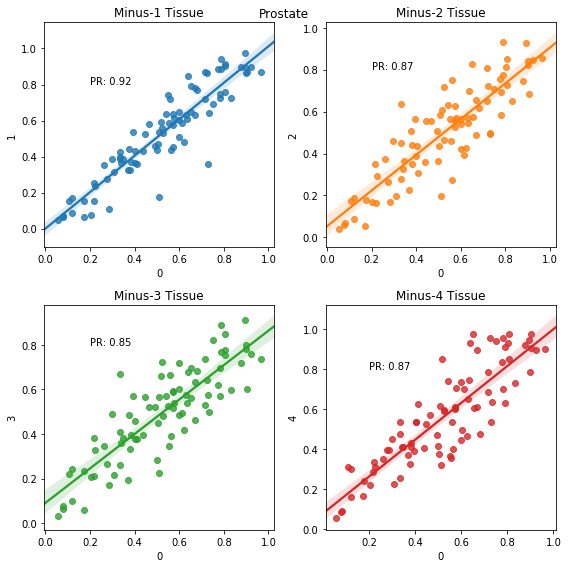

In [29]:
f, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i in range(4):
    pr, pval = st.pearsonr(pvals.dropna()[0], pvals.dropna()[i+1])
    sns.regplot(pvals.dropna()[0], pvals.dropna()[i+1], label=i+1, ax=ax[i])
    ax[i].text(0.2, 0.8, f'PR: {round(pr, 2)}')
    ax[i].set_title(f'Minus-{i+1} Tissue')
plt.suptitle(tissue)
plt.tight_layout()

# Skin

In [ ]:
tissue = 'Skin'
ran_sample = np.random.choice(tumor[tumor.tissue == tissue].index)
sample = tumor.loc[ran_sample]

In [ ]:
# Choose training set
ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]

pvals = []
for i in range(5):
    print(training_group.tissue.unique())
    last = True if i == 4 else False
    ppp, weights = protocol(sample, training_group, genes, tissue, i, last=last)
    pvals.append(ppp)
    if last:
        continue
    tissue_to_remove = weights.groupby('Class').mean().sort_values('Weights', ascending=False).index[0]
    print(f'Removing {tissue_to_remove}')
    training_group = training_group[training_group.tissue != tissue_to_remove]
pvals = pd.concat(pvals, axis=1)

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i in range(4):
    pr, pval = st.pearsonr(pvals[0], pvals[i+1])
    sns.regplot(pvals[0], pvals[i+1], label=i+1, ax=ax[i])
    ax[i].text(0.2, 0.8, f'PR: {round(pr, 2)}')
    ax[i].set_title(f'Minus-{i+1} Tissue')
plt.suptitle(tissue)
plt.tight_layout()

# Soft_tissue

In [ ]:
tissue = 'Soft_tissue'
ran_sample = np.random.choice(tumor[tumor.tissue == tissue].index)
sample = tumor.loc[ran_sample]

In [ ]:
# Choose training set
ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]

pvals = []
for i in range(5):
    print(training_group.tissue.unique())
    last = True if i == 4 else False
    ppp, weights = protocol(sample, training_group, genes, tissue, i, last=last)
    pvals.append(ppp)
    if last:
        continue
    tissue_to_remove = weights.groupby('Class').mean().sort_values('Weights', ascending=False).index[0]
    print(f'Removing {tissue_to_remove}')
    training_group = training_group[training_group.tissue != tissue_to_remove]
pvals = pd.concat(pvals, axis=1)

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i in range(4):
    pr, pval = st.pearsonr(pvals[0], pvals[i+1])
    sns.regplot(pvals[0], pvals[i+1], label=i+1, ax=ax[i])
    ax[i].text(0.2, 0.8, f'PR: {round(pr, 2)}')
    ax[i].set_title(f'Minus-{i+1} Tissue')
plt.suptitle(tissue)
plt.tight_layout()

# Stomach

In [ ]:
tissue = 'Stomach'
ran_sample = np.random.choice(tumor[tumor.tissue == tissue].index)
sample = tumor.loc[ran_sample]

In [ ]:
# Choose training set
ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]

pvals = []
for i in range(5):
    print(training_group.tissue.unique())
    last = True if i == 4 else False
    ppp, weights = protocol(sample, training_group, genes, tissue, i, last=last)
    pvals.append(ppp)
    if last:
        continue
    tissue_to_remove = weights.groupby('Class').mean().sort_values('Weights', ascending=False).index[0]
    print(f'Removing {tissue_to_remove}')
    training_group = training_group[training_group.tissue != tissue_to_remove]
pvals = pd.concat(pvals, axis=1)

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i in range(4):
    pr, pval = st.pearsonr(pvals[0], pvals[i+1])
    sns.regplot(pvals[0], pvals[i+1], label=i+1, ax=ax[i])
    ax[i].text(0.2, 0.8, f'PR: {round(pr, 2)}')
    ax[i].set_title(f'Minus-{i+1} Tissue')
plt.suptitle(tissue)
plt.tight_layout()

# Testis

In [ ]:
tissue = 'Testis'
ran_sample = np.random.choice(tumor[tumor.tissue == tissue].index)
sample = tumor.loc[ran_sample]

In [ ]:
# Choose training set
ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]

pvals = []
for i in range(5):
    print(training_group.tissue.unique())
    last = True if i == 4 else False
    ppp, weights = protocol(sample, training_group, genes, tissue, i, last=last)
    pvals.append(ppp)
    if last:
        continue
    tissue_to_remove = weights.groupby('Class').mean().sort_values('Weights', ascending=False).index[0]
    print(f'Removing {tissue_to_remove}')
    training_group = training_group[training_group.tissue != tissue_to_remove]
pvals = pd.concat(pvals, axis=1)

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i in range(4):
    pr, pval = st.pearsonr(pvals[0], pvals[i+1])
    sns.regplot(pvals[0], pvals[i+1], label=i+1, ax=ax[i])
    ax[i].text(0.2, 0.8, f'PR: {round(pr, 2)}')
    ax[i].set_title(f'Minus-{i+1} Tissue')
plt.suptitle(tissue)
plt.tight_layout()

# Thymus

In [ ]:
tissue = 'Thymus'
ran_sample = np.random.choice(tumor[tumor.tissue == tissue].index)
sample = tumor.loc[ran_sample]

In [ ]:
# Choose training set
ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]

pvals = []
for i in range(5):
    print(training_group.tissue.unique())
    last = True if i == 4 else False
    ppp, weights = protocol(sample, training_group, genes, tissue, i, last=last)
    pvals.append(ppp)
    if last:
        continue
    tissue_to_remove = weights.groupby('Class').mean().sort_values('Weights', ascending=False).index[0]
    print(f'Removing {tissue_to_remove}')
    training_group = training_group[training_group.tissue != tissue_to_remove]
pvals = pd.concat(pvals, axis=1)

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i in range(4):
    pr, pval = st.pearsonr(pvals[0], pvals[i+1])
    sns.regplot(pvals[0], pvals[i+1], label=i+1, ax=ax[i])
    ax[i].text(0.2, 0.8, f'PR: {round(pr, 2)}')
    ax[i].set_title(f'Minus-{i+1} Tissue')
plt.suptitle(tissue)
plt.tight_layout()

# Thyroid

In [47]:
tissue = 'Thyroid'
ran_sample = np.random.choice(tumor[tumor.tissue == tissue].index)
sample = tumor.loc[ran_sample]

In [48]:
# Choose training set
ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]

pvals = []
for i in range(5):
    print(training_group.tissue.unique())
    last = True if i == 4 else False
    ppp, weights = protocol(sample, training_group, genes, tissue, i, last=last)
    pvals.append(ppp)
    if last:
        continue
    tissue_to_remove = weights.groupby('Class').mean().sort_values('Weights', ascending=False).index[0]
    print(f'Removing {tissue_to_remove}')
    training_group = training_group[training_group.tissue != tissue_to_remove]
pvals = pd.concat(pvals, axis=1)

['Adrenal' 'Kidney' 'Minor' 'Stomach' 'Thyroid']
Building model


INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock

Sampling 4 chains: 100%|██████████| 4000/4000 [11:48<00:00,  2.37draws/s] 


Removing Thyroid
['Adrenal' 'Kidney' 'Minor' 'Stomach']
Building model


INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock

Removing Minor
['Adrenal' 'Kidney' 'Stomach']
Building model


INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PARP1-Stomach, PARP1-Kidney, PARP1-Adrenal, AURKC-Stomach, AURKC-Kidney, AURKC-Adrenal, AURKB-Stomach, AURKB-Kidney, AURKB-Adrenal, AURKA-Stomach, AURKA-Ki

Removing Stomach
['Adrenal' 'Kidney']
Building model


INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PARP1-Kidney, PARP1-Adrenal, AURKC-Kidney, AURKC-Adrenal, AURKB-Kidney, AURKB-Adrenal, AURKA-Kidney, AURKA-Adrenal, MS4A1-Kidney, MS4A1-Adrenal, BTK-Kidney, BTK-Adrenal, HSP90B1-Kidney, HSP90B1-Adrenal, HSP90AB3P-Kidney, HSP90AB3P-Adrenal, HSP90AB1-Kidney, HSP90AB1-Adrenal, HSP90AA1-Kidney, HSP90AA1-Adrenal, MDM2

Removing Kidney
['Adrenal']
Building model


INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PARP1-Adrenal, AURKC-Adrenal, AURKB-Adrenal, AURKA-Adrenal, MS4A1-Adrenal, BTK-Adrenal, HSP90B1-Adrenal, HSP90AB3P-Adrenal, HSP90AB1-Adrenal, HSP90AA1-Adre

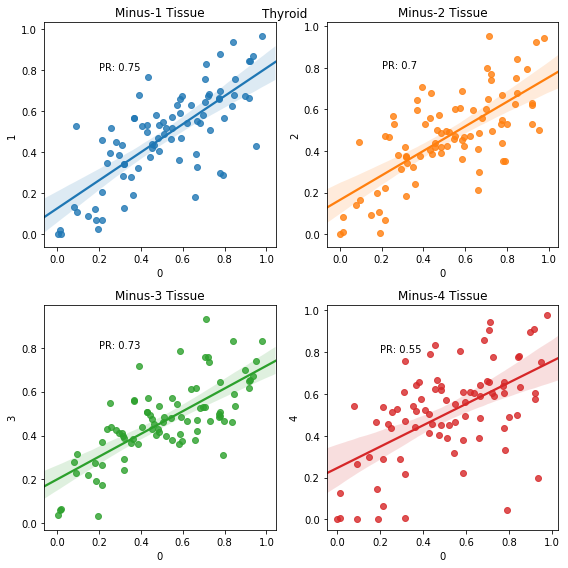

In [49]:
f, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i in range(4):
    pr, pval = st.pearsonr(pvals[0], pvals[i+1])
    sns.regplot(pvals[0], pvals[i+1], label=i+1, ax=ax[i])
    ax[i].text(0.2, 0.8, f'PR: {round(pr, 2)}')
    ax[i].set_title(f'Minus-{i+1} Tissue')
plt.suptitle(tissue)
plt.tight_layout()

# Uterus

In [ ]:
tissue = 'Uterus'
ran_sample = np.random.choice(tumor[tumor.tissue == tissue].index)
sample = tumor.loc[ran_sample]

In [ ]:
# Choose training set
ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]

pvals = []
for i in range(5):
    print(training_group.tissue.unique())
    last = True if i == 4 else False
    ppp, weights = protocol(sample, training_group, genes, tissue, i, last=last)
    pvals.append(ppp)
    if last:
        continue
    tissue_to_remove = weights.groupby('Class').mean().sort_values('Weights', ascending=False).index[0]
    print(f'Removing {tissue_to_remove}')
    training_group = training_group[training_group.tissue != tissue_to_remove]
pvals = pd.concat(pvals, axis=1)

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i in range(4):
    pr, pval = st.pearsonr(pvals[0], pvals[i+1])
    sns.regplot(pvals[0], pvals[i+1], label=i+1, ax=ax[i])
    ax[i].text(0.2, 0.8, f'PR: {round(pr, 2)}')
    ax[i].set_title(f'Minus-{i+1} Tissue')
plt.suptitle(tissue)
plt.tight_layout()

# Check Inclusion of SKB Genes on Beta Coefficient Weights

For samples whose highest weight isn't the associative normal, see if adding SKB genes rectifies or modifies the beta coefficients drastically

It absolutely matters. 